# Question 3

This script compares a band pass FIR filter filter designed using the windowing method with an optimal filter designed using the Parks-McClellan method (Remez exchange algorithm).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

In [2]:
# Define filter specifications

F_SAMP  = 40        # sampling frequency, kHz
PASS_BAND = [4, 6]  # pass band, kHz
DELTA_F = 1         # transition width, kHz
A_STOP  = 60        # stop band attenuation, dB

### Windowing Method

In [3]:
# Initial estimate of filter length using Harris formula
N = int(np.ceil((F_SAMP / DELTA_F) * (A_STOP / 22)))
print("Filter length estimate:", N)

Filter length estimate: 110


Create the frequency domain vector, $V$, which represents the ideal frequency response.

Bins in passband: 6


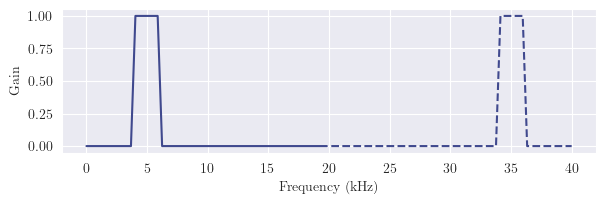

In [4]:
# Calculate pass band width, L
L = int(np.round(N * (PASS_BAND[1] - PASS_BAND[0]) / F_SAMP))
print("Bins in passband:", L)

# Construct V, with 1's in the pass band and 0's in the stop band
L_idx = np.where(np.linspace(0, F_SAMP, N) >= PASS_BAND[0])[0][0]
V = np.zeros(N//2)
V[L_idx:L_idx+L] = np.ones(L)
V = np.concatenate([V, V[::-1]])

# Construct a frequency axis for plotting
f = np.linspace(0, F_SAMP, N)

# Plot the ideal frequency response, represented by vector V
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

palette = sns.color_palette()

sns.lineplot(x=f[:N//2], y=V[:N//2], ax=ax, c=palette[0], ls="-")
sns.lineplot(x=f[N//2:], y=V[N//2:], ax=ax, c=palette[0], ls="--")

ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Gain")

fname = Path(A2_ROOT, "output", "q3_ideal_freqz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

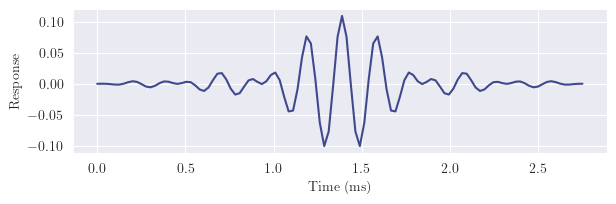

In [5]:
from scipy.fft import fft, fftshift, ifft

# Impulse (time) response of ideal filter
v = fftshift(ifft(V))

# Plot the ideal impulse response
fig, ax = plt.subplots(figsize=(6, 2))
fig.tight_layout()

t = np.linspace(0, N / F_SAMP, N)
sns.lineplot(x=t, y=v.real, ax=ax)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Response")

fname = Path(A2_ROOT, "output", "q3_ideal_impz.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

In [6]:
# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

def plot_freqz(w, h, ax=None, fname=None, save=False):
    """Plot frequency response and overlay filter requirements."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
        fig.tight_layout()
        axes_local = True
    else:
        axes_local = False
    sns.lineplot(x=w, y=dB(np.abs(h)), ax=ax)
    # Plot stop band requirement
    ax.axhline(-60, c="r", lw=0.5, label="Stop band requirement")
    ax.axvline(  3, c="r", lw=0.5)
    ax.axvline(  7, c="r", lw=0.5)
    # Plot pass band requirement
    ax.axhline( -1, c="g", lw=0.5, label="Pass band requirement")
    ax.axvline(  4, c="g", lw=0.5)
    ax.axvline(  6, c="g", lw=0.5)
    # Axis labels
    ax.set_xlabel("Frequency (kHz)")
    ax.set_ylabel("Gain (dB)")
    ax.legend(framealpha=1)
    # Save or just show
    if save:
        if not axes_local:
            raise RuntimeError("save is True but the axes were not created locally")
        if not fname:
            raise RuntimeError("save is True but no file name was provided")
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    if axes_local:
        plt.show()

/tmp/ipykernel_14198/353762021.py:2: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)


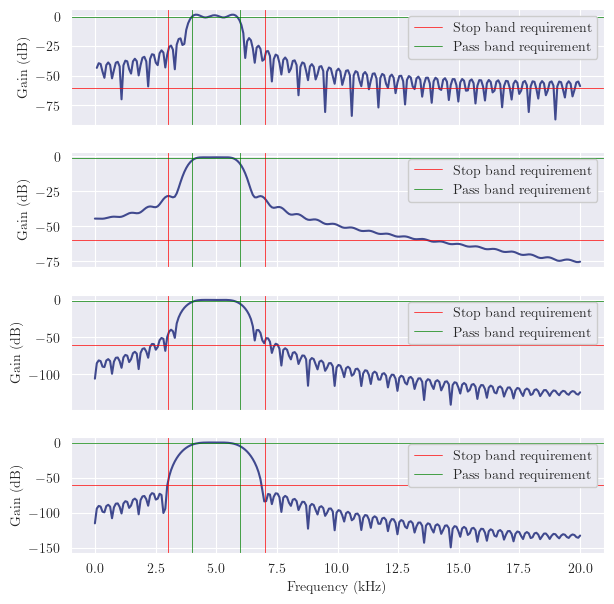

In [7]:
from scipy.signal.windows import bartlett, blackman, boxcar, hann

V_boxcar   = np.round(np.abs(fft(v * boxcar(N),   512)[:256]), decimals=10)
V_bartlett = np.round(np.abs(fft(v * bartlett(N), 512)[:256]), decimals=10)
V_hann     = np.round(np.abs(fft(v * hann(N),     512)[:256]), decimals=10)
V_blackman = np.round(np.abs(fft(v * blackman(N), 512)[:256]), decimals=10)

# Construct a frequency axis for plotting
f = np.linspace(0, F_SAMP / 2, 256)

# Plot the comparison
fig, axs = plt.subplots(4, figsize=(6, 6), sharex=True)
fig.tight_layout()

plot_freqz(f, V_boxcar,   ax=axs[0])
plot_freqz(f, V_bartlett, ax=axs[1])
plot_freqz(f, V_hann,     ax=axs[2])
plot_freqz(f, V_blackman, ax=axs[3])

fname = Path(A2_ROOT, "output", "q3_window_freqzs.png")
fig.savefig(fname, **SAVEFIG_CONFIG)

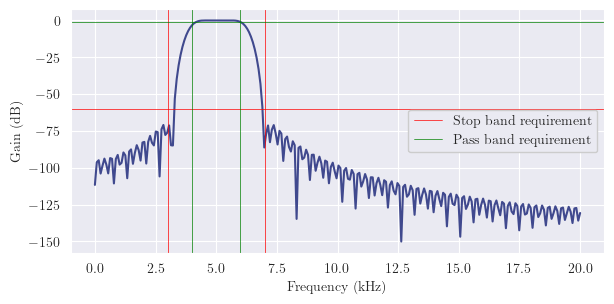

In [12]:
# Increase N until roll-off specification is met
N = 150

L = int(np.round(N * (PASS_BAND[1] - PASS_BAND[0]) / F_SAMP)) + 1
L_idx = np.where(np.linspace(0, F_SAMP, N) >= PASS_BAND[0])[0][0]
V = np.zeros(N//2)
V[L_idx:L_idx+L] = np.ones(L)
V = np.concatenate([V, V[::-1]])

v = fftshift(ifft(V))
V_blackman = np.round(np.abs(fft(v * blackman(N), 512)[:256]), decimals=10)

plot_freqz(f, V_blackman, fname="q3_blackman_freqz.png", save=True)

### Parks-McClellan Method

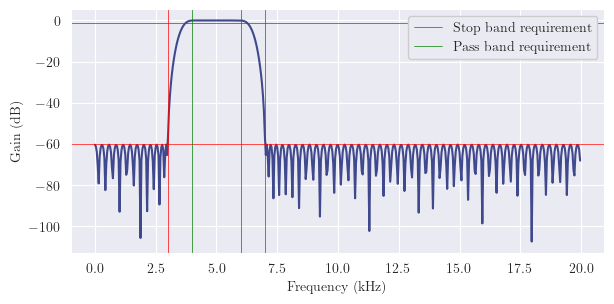

In [ ]:
# Optimal filter design using Parks-McClellan method (Remez exchange algorithm)
import scipy.signal as signal

numtaps = 140
edges = [0, F1 - DELTA_F, F1, F2, F2 + DELTA_F, 0.5 * FS]
taps = signal.remez(numtaps, edges, [0, 1, 0], fs=FS)
w, h = signal.freqz(taps, [1], fs=FS)
plot_freqz(w, h, fname="q3_optimal_freqz.png", save=True)